# Warsztaty modelowania w nanofizyce
----
## Obliczenia z pierwszych zasad

**Paweł T. Jochym**

Zakład Komputerowych Badań Materiałów

Instytut Fizyki Jądrowej PAN, Kraków

---

Przekonajmy się jaka jest faktyczna stała sieci diamentu. Użyjemy w tym celu programu abinit. Komórka elementarna diamentu zawiera jedynie dwa atomy więc nasz rachunek nie powinien trwać zbyt długo. Procedura składa się zasadniczo z następujących kroków:

1. Konfiguracja programu obliczeniowego (kalkulatora)
2. Budowa struktur
3. Uruchomienie obliczeń
4. Zebranie wyników i ich interpretacja
5. Modyfikacja parametrów obliczeń/struktur
6. Powrót do punktu 3

**Uwaga: Parametry rachunku użyte poniżej dobrane zostały tak aby uzyskać wynik zbliżony do prawidłowego w krótkim czasie. W żadnym razie nie należy ich używać jako rozsądnych parametrów startowych dla prawdziwych obliczeń.** 

**Śmieć na wejściu - Śmieć na wyjściu**

In [1]:
# Import potrzebnych modułów
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
from ase.build import bulk
from ase import units
import ase.io
from IPython.core.display import Image
from __future__ import division, print_function

In [2]:
from ase import Atoms
from ase.units import Ry
from ase.calculators.abinit import Abinit
import os
import sys

In [3]:
# Konfiguracja programu abinit
os.environ['ASE_ABINIT_COMMAND']='abinit < PREFIX.files > PREFIX.log'
os.environ['ABINIT_PP_PATH']='abinit_psp/GGA_FHI/:abinit_psp/LDA_FHI/:abinit_psp/LDA_PAW/:abinit_psp/GGA_PAW/'

### Tworzenie struktury

Zdefiniowanie struktury wymaga podania jej składu atomowego oraz pozycji jej składników. W przypadku struktur krystalicznych powinniśmy także określić ich symeterię oraz rozmiar i rodzaj ich komórki elementarnej.

Zacznijmy od jednej z najprostszych struktur krystalicznych - diamentu. Jej podstawowy element, komórka elementarna, zawiera zaledwie dwa atomy.

Utworzoną strukturę warto wyświetlić dla kontroli poprawności.

In [4]:
diam = bulk(name='C',crystalstructure='diamond',a=4)
diam.get_cell()

array([[ 0.,  2.,  2.],
       [ 2.,  0.,  2.],
       [ 2.,  2.,  0.]])

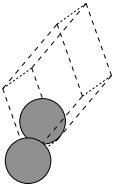

In [5]:
# Zapis obrazu kryształu na dysk
ase.io.write('diament.png',       # Nazwa pliku
             diam,             # obiekt zawierający definicję struktury
             show_unit_cell=2,    # Rysowanie komórki elementarnej
             rotation='115y,15x', # Obrót 115st wokół osi Y i 15st wokół osi X
             scale=30)            # Skala

# Wyświetlamy
Image(filename='diament.png')

### Przygotowanie programu do obliczeń

Programy do obliczeń kwantowo-mechanicznych wymagają ustalenia wielu parametrów rachunku. Aby uzyskane wyniki miały jakąkolwiek wartość dobór tych parametrów musi być wykonany bardzo starannie. Parametry użyte poniżej zostały dobrane tak aby obliczenia przebiegały szybko. Prowadzi to do dużej niedokładności uzyskanuych wyników. 

**W żadnym przypadku nie należy traktować użytych tutaj parametrów jako wzoru do naśladowania w realnej pracy badawczej**

In [6]:
calc = Abinit(label='diam',
              nbands=8,  
              ecut=20 * Ry,  # Uwaga! 
              kpts=[4, 4, 4],  # Uwaga!
              chksymbreak=0,
              )


calc.set(toldfe=1.0e-3)  # Uwaga!

In [7]:
# Pusta lista na wyniki
e_vs_a=[]

# Iterujemy po stałej sieci
for a in np.linspace(3,5,5):
    # W sieci diamentu składowe wektorów wynoszą a0/2
    b = a / 2
    
    # Ustawiamy komórkę na nowe rozmiary
    diam.set_cell([(0, b, b),
                   (b, 0, b),
                   (b, b, 0)], scale_atoms=True)

    # Przypisujemy procedurę obliczeniową
    diam.set_calculator(calc)
    
    # Faktyczne wywołanie programu abinit
    e = diam.get_potential_energy()
    
    # Dodajemy wynik do listy
    e_vs_a.append([a,e])
    
    # Monitorowanie postępów
    print('a: %5f e: %5f' % (a,e))
    sys.stdout.flush()
    
# Konwersja na wygodniejszą postać (macierz)
e_vs_a=np.array(e_vs_a).T

a: 3.000000 e: -297.676505
a: 3.500000 e: -305.357851
a: 4.000000 e: -303.990511
a: 4.500000 e: -300.691428
a: 5.000000 e: -298.132358


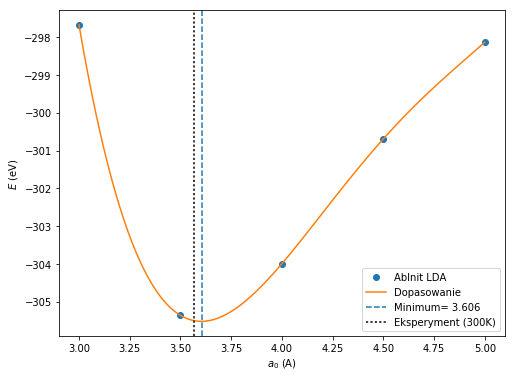

In [8]:
# Wykres wyników
plt.figure(figsize=(8,6))

# Wyliczone punkty
plt.plot(e_vs_a[0],e_vs_a[1],'o',label='AbInit LDA')

# Dopasowanie wielomianu
fit=np.polyfit(e_vs_a[0],e_vs_a[1],4)

# I jego wykres
x=np.linspace(e_vs_a[0].min(),e_vs_a[0].max(),100)
plt.plot(x,np.polyval(fit,x),'-',label=u'Dopasowanie')

# Dodatkowe elementy rysunku
plt.axvline(x[np.polyval(fit,x).argmin()],ls='--',
            label='Minimum=%6.3f' % (x[np.polyval(fit,x).argmin()],))
plt.axvline(3.56683,ls=':',color='k',label='Eksperyment (300K)')

# Opisy
plt.legend(loc='best')
plt.xlabel('$a_0$ (A)')
plt.ylabel('$E$ (eV)');

Sprawdźmy jakie są naprężenia struktury optymalnej.

In [9]:
# Ustawmy a0 na najmniejszy punkt fitu
a0=x[np.polyval(fit,x).argmin()]
b = a0 / 2

# Ustawiamy komórkę na nowe rozmiary
diam.set_cell([(0, b, b),
               (b, 0, b),
               (b, b, 0)], scale_atoms=True)
diam.set_calculator(calc)
stres=diam.get_stress()
print(stres/units.GPa)

[ 131.85632625  131.85632625  131.85632625    0.            0.            0.        ]


### Dopasowanie równania stanu

Dopasujmy logarytmiczne równanie stanu Bircha-Murnaghana do zależności objętość-ciśnienie dla naszego kryształu aby uzyskać:

* Równowagową stałą sieci $A_0$
* Objętościowy moduł ściśliwości $B_0$
* Objętościową pochodną modułu ściśliwości $B'_0$

Równanie Bircha-Murnaghana ma postać:

$$
P(V)=\frac{B_0}{B'_0} \left[\left(\frac{V_0}{V}\right)^{B'_0}-1\right]
$$

Aby dopasować powyższą funkcję do wyliczonych punktów użyjemy procedury dopasowania nieliniowych funkcji (`leastsq`) z modułu `optimize` biblioteki `SciPy`. Dokumentację tej i pozostałych bibliotek można znaleźć w menu Help powyzej.

W pierwszej kolejności musmy wyliczyć punkty objętość-ciśnienie analogicznie jak poprzednio w zakresie +/- 5% od $a_0$. Następnie dopasujemy równanie stanu do otrzymanych punktów. Eksperymentalne $B_0$ diamentu wynosi 443 GPa.


In [10]:
# Miejsce na wynik
wynik=[]
for a in np.linspace(a0*0.95,a0*1.05,5):
    # W sieci diamentu składowe wektorów wynoszą a0/2
    b = a / 2
    
    # Ustawiamy komórkę na nowe rozmiary
    diam.set_cell([(0, b, b),
                   (b, 0, b),
                   (b, b, 0)], scale_atoms=True)

    # Przypisujemy procedurę obliczeniową
    diam.set_calculator(calc)
    
    # Faktyczne wywołanie programu abinit
    # W równaniu stanu występuje ciśnienie zewnętrzne - stąd minus
    stres = -(diam.get_stress()[:3]).mean()/units.GPa
    
    # Dodajemy wynik do listy
    wynik.append([diam.get_volume(),stres])
    
    # Monitorowanie postępów
    print('V: %7.2f A^3   P: %7.2f GPa' % (diam.get_volume(),stres))
    sys.stdout.flush()

wynik=np.array(wynik).T

V:   10.05 A^3   P:  -82.22 GPa
V:   10.87 A^3   P: -111.26 GPa
V:   11.72 A^3   P: -131.86 GPa
V:   12.62 A^3   P: -145.65 GPa
V:   13.57 A^3   P: -153.69 GPa


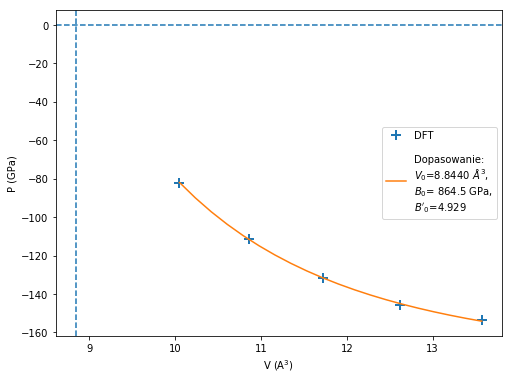

In [11]:
# Moduł dopasowania
from scipy import optimize

# Definicja funkcji stanu
def BMEOS(v,v0,b0,b0p):
        return (b0/b0p)*(pow(v0/v,b0p) - 1)

# Funkcje pomocnicze potrzebne do procedury dopasowania
# Funkcja dopasowywana oraz rezidua
fitfunc = lambda p, x: [BMEOS(xv,p[0],p[1],p[2]) for xv in x]
errfunc = lambda p, x, y: fitfunc(p, x) - y

plt.figure(figsize=(8,6))
plt.plot(wynik[0],wynik[1],'+',markersize=10,markeredgewidth=2,label='DFT')

# Dopasowanie równania stanu

# Wstępne wartości przy założeniu b0p=1
# Końce przedziału
v1=min(wynik[0])
v2=max(wynik[0])
# Ciśnienie jest funkcją malejącą objętości
p2=min(wynik[1])
p1=max(wynik[1])

# Oszacowanie nachylenia
b0=(p1*v1-p2*v2)/(v2-v1)
v0=(v1)*(p1+b0)/b0

# Parametry startowe
p0=[v0,b0,1]

# Dopasowanie
fit, succ = optimize.leastsq(errfunc, p0[:], args=(wynik[0],wynik[1]))

# Zakres zmienności
x=np.array([min(wynik[0]),max(wynik[0])])
y=np.array([min(wynik[1]),max(wynik[1])])

# Wykres P(V) (punkty + dopasowanie)

# Oznaczmy pozycję P=0, A=A0
plt.axvline(fit[0],ls='--')
plt.axhline(0,ls='--')

# Wykres rezultatów
xa=np.linspace(x[0],x[-1],20)
plt.plot(xa,fitfunc(fit,xa),'-', 
     label="\nDopasowanie:\n$V_0$=%6.4f $\AA^3$,\n$B_0$=%6.1f GPa,\n$B'_0$=%5.3f  " % (fit[0], fit[1], fit[2]) )

plt.legend()
plt.xlabel('V (A$^3$)')
plt.ylabel('P (GPa)')

# Zapiszmy rysunek jako plik PDF
plt.savefig('p-vs-v.pdf')

### Analiza wyników

Jak widzimy z powyższego wykresu parametry użyte do obliczeń doprowadziły nas do niespójnych rezultatów. Dwie metody wyznaczenia objętości równowagowej kryształu dały drastycznie różne rezultaty. Pokazuje to jasno jak duże znaczenie ma staranny dobór parametrów obliczeń dla wartości uzyskanych wyników. Nie wolno przyjmować pierwszego uzyskanego rezultatu jako poprawnego. Uzyskanie wartościowych wyników wymaga każdorazowej analizy wpływu parametrów rachunku na uzyskane wyniki.

Należy wrócić do punktu "Przygotowanie programu do obliczeń" powyżej i przekonać się jakie wartości parametrów należy ustalić aby uzyskać spójne rezultaty.